In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib as mpl
import os
import catboost as cb
from collections import Counter

from IPython.core.pylabtools import figsize
from scipy import stats

In [2]:
#Getting Working Directory
os.getcwd()

#Setting style and font size for graphs
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 13

In [3]:
#load original data into dataframe
file ='train_cat.csv'
df = pd.read_csv(file)
df.shape

(7377415, 70)

In [4]:
df['isrc_year'] = df.isrc_year.apply(lambda x: x if x != 'year_missing' else -1)
df['isrc_year'] = df['isrc_year'].astype('int8')

#Converting to categories
cat_names = list(df.select_dtypes(include='object').columns)
df[cat_names] = df[cat_names].astype('category')
#df['language'] = df['language'].astype('category')

int_names = list(df.select_dtypes(include='int64').columns)
df[int_names] = df[int_names].astype('int16')

int_names_8 = ['composer_artist_lyricist', 'composer_artist']
df[int_names_8] = df[int_names_8].astype('uint8')


float_names = list(df.select_dtypes(include='float64').columns)
float_names.remove('song_length')
df[float_names] = df[float_names].astype('float16')

float_names = list(df.select_dtypes(include='float64').columns)
df[float_names] = df[float_names].astype('float32')


ua = ['usr_1', 'usr_2', 'usr_3', 'genre_ids_encoded'] #, 'song_freq', 'ua_1', 'ua_2', 'ua_3','ua_4','ua_5','ua_6','ua_7','ua_8','ua_9','ua_10']
df.drop(ua, axis=1, inplace = True)

#Converting to categories
#cat_names = ['source_system_tab', 'source_screen_name','source_type','gender']

#df[cat_names] = df[cat_names].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377415 entries, 0 to 7377414
Data columns (total 66 columns):
source_system_tab           category
source_screen_name          category
source_type                 category
target                      int16
song_length                 float32
genre_ids                   category
artist_name                 category
composer                    category
lyricist                    category
language                    float16
city                        int16
bd                          int16
gender                      category
registered_via              int16
name                        category
lyricist_count              int16
artist_count                int16
composer_count              int16
genre_count                 int16
isrc_country                category
isrc_year                   int8
duration                    float16
registration_year           int16
registration_month          int16
registration_day            int16
re

In [5]:
# Separating Numeric and Non_numeric Data
cat_names = ['source_system_tab', 'source_screen_name','source_type','gender']

categorical = df.drop(df.columns.difference(cat_names),axis = 1)
numeric = df.drop(cat_names, axis = 1)


#Creating Dummy variables for Categorical Data using One Hot Encoding
dummies = pd.get_dummies(categorical,drop_first = True)


In [6]:
X = pd.concat([numeric,dummies],axis=1).drop('target', axis = 1)
y = df.target
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377415 entries, 0 to 7377414
Columns: 103 entries, song_length to gender_male
dtypes: category(6), float16(34), float32(1), int16(17), int8(1), uint8(44)
memory usage: 1.2 GB


In [7]:
#Identifying index of Categorical data
cat_index = [1,2,3,4,9,14]

In [8]:
z = X_test_s.columns
z[cat_index]

NameError: name 'X_test_s' is not defined

In [9]:
#Splitting Data into Training and Test Data Set
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
mean_length = X_train.song_length.mean()
X_train.song_length.fillna(mean_length, inplace = True)
X_test.song_length.fillna(mean_length, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [10]:
X_train.shape

(3688707, 103)

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3688707 entries, 1069668 to 6413414
Columns: 103 entries, song_length to gender_male
dtypes: category(6), float16(34), float32(1), int16(17), int8(1), uint8(44)
memory usage: 644.1 MB


There are two types of error, False Positive and False Negative. Predicting that a patient will not get readmitted but actually patient gets readmitted. This is false negative. Predicting that a patient will get readmitted but in actually he will not os called false positive. For an hospital, a false negative error is not desirable. They can still live with a false positive error. So in below models we will look at reducing false negative error. 

High Recall for class 'Readmitted', Better the model


Ensuring that we have the same fractions of all class in both train and test data set. Let's Calculate the fraction

### CatBoost Classifier

In [12]:
# Base Line Evaluation
from sklearn.metrics import classification_report, balanced_accuracy_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support,log_loss
class_names = ['Not Learning', 'Learning']

In [13]:
def auc_curve(y_test,y_pred_test,auc_test):
    fpr,tpr, threshold = roc_curve(y_test, y_pred_test)
    _ = plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' %auc_test )
    _ = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = plt.xlim([0.0, 1.0])
    _ = plt.ylim([0.0, 1.05])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic example')
    _ = plt.legend(loc="lower right")


In [62]:
cb_clf = cb.CatBoostClassifier(random_state = 42, one_hot_max_size = 40)
cb_clf.fit(X_train, y_train, cat_features= cat_index)

Learning rate set to 0.343549
0:	learn: 0.6581796	total: 8.57s	remaining: 2h 22m 43s
1:	learn: 0.6399825	total: 16.3s	remaining: 2h 15m 24s
2:	learn: 0.6300491	total: 23.9s	remaining: 2h 12m 19s
3:	learn: 0.6246511	total: 30.8s	remaining: 2h 7m 48s
4:	learn: 0.6212688	total: 38.1s	remaining: 2h 6m 29s
5:	learn: 0.6183913	total: 44.5s	remaining: 2h 2m 56s
6:	learn: 0.6163900	total: 51.1s	remaining: 2h 51s
7:	learn: 0.6140579	total: 57.2s	remaining: 1h 58m 10s
8:	learn: 0.6117794	total: 1m 3s	remaining: 1h 56m 27s
9:	learn: 0.6102647	total: 1m 9s	remaining: 1h 55m 11s
10:	learn: 0.6081038	total: 1m 16s	remaining: 1h 54m 47s
11:	learn: 0.6067385	total: 1m 23s	remaining: 1h 54m 10s
12:	learn: 0.6053326	total: 1m 29s	remaining: 1h 53m 7s
13:	learn: 0.6043245	total: 1m 36s	remaining: 1h 53m 37s
14:	learn: 0.6035802	total: 1m 44s	remaining: 1h 53m 49s
15:	learn: 0.6027004	total: 1m 50s	remaining: 1h 53m 32s
16:	learn: 0.6011031	total: 1m 56s	remaining: 1h 52m 15s
17:	learn: 0.6005268	total: 2

144:	learn: 0.5661797	total: 11m 30s	remaining: 1h 7m 50s
145:	learn: 0.5660020	total: 11m 34s	remaining: 1h 7m 41s
146:	learn: 0.5658578	total: 11m 38s	remaining: 1h 7m 30s
147:	learn: 0.5657503	total: 11m 42s	remaining: 1h 7m 21s
148:	learn: 0.5655504	total: 11m 46s	remaining: 1h 7m 14s
149:	learn: 0.5653848	total: 11m 50s	remaining: 1h 7m 7s
150:	learn: 0.5652796	total: 11m 54s	remaining: 1h 6m 59s
151:	learn: 0.5651612	total: 11m 58s	remaining: 1h 6m 51s
152:	learn: 0.5649924	total: 12m 4s	remaining: 1h 6m 48s
153:	learn: 0.5648316	total: 12m 8s	remaining: 1h 6m 44s
154:	learn: 0.5646913	total: 12m 15s	remaining: 1h 6m 47s
155:	learn: 0.5645789	total: 12m 20s	remaining: 1h 6m 43s
156:	learn: 0.5644663	total: 12m 24s	remaining: 1h 6m 37s
157:	learn: 0.5643582	total: 12m 28s	remaining: 1h 6m 30s
158:	learn: 0.5641844	total: 12m 33s	remaining: 1h 6m 23s
159:	learn: 0.5640241	total: 12m 37s	remaining: 1h 6m 15s
160:	learn: 0.5639298	total: 12m 41s	remaining: 1h 6m 10s
161:	learn: 0.563

290:	learn: 0.5520517	total: 21m 58s	remaining: 53m 32s
291:	learn: 0.5519898	total: 22m 2s	remaining: 53m 25s
292:	learn: 0.5518740	total: 22m 6s	remaining: 53m 20s
293:	learn: 0.5517984	total: 22m 10s	remaining: 53m 14s
294:	learn: 0.5517347	total: 22m 14s	remaining: 53m 8s
295:	learn: 0.5516677	total: 22m 18s	remaining: 53m 2s
296:	learn: 0.5516069	total: 22m 22s	remaining: 52m 58s
297:	learn: 0.5515616	total: 22m 27s	remaining: 52m 53s
298:	learn: 0.5514796	total: 22m 31s	remaining: 52m 49s
299:	learn: 0.5514035	total: 22m 36s	remaining: 52m 44s
300:	learn: 0.5513450	total: 22m 40s	remaining: 52m 39s
301:	learn: 0.5512733	total: 22m 45s	remaining: 52m 35s
302:	learn: 0.5512138	total: 22m 49s	remaining: 52m 29s
303:	learn: 0.5511677	total: 22m 53s	remaining: 52m 23s
304:	learn: 0.5510912	total: 22m 57s	remaining: 52m 18s
305:	learn: 0.5510304	total: 23m 1s	remaining: 52m 14s
306:	learn: 0.5509570	total: 23m 6s	remaining: 52m 9s
307:	learn: 0.5508873	total: 23m 10s	remaining: 52m 5s


438:	learn: 0.5432858	total: 33m 1s	remaining: 42m 12s
439:	learn: 0.5432317	total: 33m 6s	remaining: 42m 8s
440:	learn: 0.5431750	total: 33m 11s	remaining: 42m 4s
441:	learn: 0.5431289	total: 33m 15s	remaining: 41m 59s
442:	learn: 0.5430828	total: 33m 20s	remaining: 41m 54s
443:	learn: 0.5430335	total: 33m 24s	remaining: 41m 49s
444:	learn: 0.5429979	total: 33m 27s	remaining: 41m 44s
445:	learn: 0.5429556	total: 33m 32s	remaining: 41m 39s
446:	learn: 0.5429073	total: 33m 36s	remaining: 41m 34s
447:	learn: 0.5428532	total: 33m 39s	remaining: 41m 28s
448:	learn: 0.5427807	total: 33m 44s	remaining: 41m 24s
449:	learn: 0.5427421	total: 33m 48s	remaining: 41m 19s
450:	learn: 0.5426948	total: 33m 52s	remaining: 41m 14s
451:	learn: 0.5426683	total: 33m 56s	remaining: 41m 9s
452:	learn: 0.5426172	total: 34m	remaining: 41m 4s
453:	learn: 0.5425891	total: 34m 4s	remaining: 40m 58s
454:	learn: 0.5425321	total: 34m 8s	remaining: 40m 53s
455:	learn: 0.5424854	total: 34m 13s	remaining: 40m 49s
456:

586:	learn: 0.5366339	total: 43m 52s	remaining: 30m 52s
587:	learn: 0.5365991	total: 43m 57s	remaining: 30m 47s
588:	learn: 0.5365677	total: 44m	remaining: 30m 42s
589:	learn: 0.5365089	total: 44m 5s	remaining: 30m 38s
590:	learn: 0.5364782	total: 44m 9s	remaining: 30m 33s
591:	learn: 0.5364516	total: 44m 14s	remaining: 30m 29s
592:	learn: 0.5364162	total: 44m 18s	remaining: 30m 24s
593:	learn: 0.5363919	total: 44m 22s	remaining: 30m 19s
594:	learn: 0.5363593	total: 44m 26s	remaining: 30m 14s
595:	learn: 0.5363303	total: 44m 31s	remaining: 30m 10s
596:	learn: 0.5362939	total: 44m 35s	remaining: 30m 6s
597:	learn: 0.5362691	total: 44m 40s	remaining: 30m 1s
598:	learn: 0.5361966	total: 44m 44s	remaining: 29m 57s
599:	learn: 0.5361565	total: 44m 48s	remaining: 29m 52s
600:	learn: 0.5361204	total: 44m 52s	remaining: 29m 47s
601:	learn: 0.5360594	total: 44m 56s	remaining: 29m 42s
602:	learn: 0.5360317	total: 45m	remaining: 29m 37s
603:	learn: 0.5359568	total: 45m 4s	remaining: 29m 33s
604:	

734:	learn: 0.5313077	total: 54m 41s	remaining: 19m 43s
735:	learn: 0.5312766	total: 54m 48s	remaining: 19m 39s
736:	learn: 0.5312235	total: 54m 54s	remaining: 19m 35s
737:	learn: 0.5311713	total: 55m 2s	remaining: 19m 32s
738:	learn: 0.5311304	total: 55m 11s	remaining: 19m 29s
739:	learn: 0.5311096	total: 55m 18s	remaining: 19m 26s
740:	learn: 0.5310820	total: 55m 26s	remaining: 19m 22s
741:	learn: 0.5310599	total: 55m 32s	remaining: 19m 18s
742:	learn: 0.5310280	total: 55m 40s	remaining: 19m 15s
743:	learn: 0.5309820	total: 55m 46s	remaining: 19m 11s
744:	learn: 0.5309414	total: 55m 52s	remaining: 19m 7s
745:	learn: 0.5308972	total: 55m 57s	remaining: 19m 3s
746:	learn: 0.5308709	total: 56m 1s	remaining: 18m 58s
747:	learn: 0.5308521	total: 56m 5s	remaining: 18m 53s
748:	learn: 0.5308033	total: 56m 8s	remaining: 18m 48s
749:	learn: 0.5307748	total: 56m 12s	remaining: 18m 44s
750:	learn: 0.5307471	total: 56m 16s	remaining: 18m 39s
751:	learn: 0.5307121	total: 56m 20s	remaining: 18m 34

880:	learn: 0.5266819	total: 1h 4m 55s	remaining: 8m 46s
881:	learn: 0.5266513	total: 1h 4m 59s	remaining: 8m 41s
882:	learn: 0.5266186	total: 1h 5m 3s	remaining: 8m 37s
883:	learn: 0.5266005	total: 1h 5m 7s	remaining: 8m 32s
884:	learn: 0.5265859	total: 1h 5m 11s	remaining: 8m 28s
885:	learn: 0.5265587	total: 1h 5m 15s	remaining: 8m 23s
886:	learn: 0.5265422	total: 1h 5m 18s	remaining: 8m 19s
887:	learn: 0.5265182	total: 1h 5m 22s	remaining: 8m 14s
888:	learn: 0.5264888	total: 1h 5m 26s	remaining: 8m 10s
889:	learn: 0.5264651	total: 1h 5m 29s	remaining: 8m 5s
890:	learn: 0.5264426	total: 1h 5m 33s	remaining: 8m 1s
891:	learn: 0.5264231	total: 1h 5m 37s	remaining: 7m 56s
892:	learn: 0.5263904	total: 1h 5m 41s	remaining: 7m 52s
893:	learn: 0.5263687	total: 1h 5m 45s	remaining: 7m 47s
894:	learn: 0.5263442	total: 1h 5m 48s	remaining: 7m 43s
895:	learn: 0.5263292	total: 1h 5m 52s	remaining: 7m 38s
896:	learn: 0.5263129	total: 1h 5m 56s	remaining: 7m 34s
897:	learn: 0.5262830	total: 1h 6m	

In [40]:
cb_clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorde

Training accuracy: 0.7633
Test accuracy    : 0.7361
Training AUC Score: 0.8452
Testing AUC Score: 0.8141
Classification Report - Training
              precision    recall  f1-score   support

           0       0.76      0.76      0.76   1832448
           1       0.76      0.77      0.77   1856259

    accuracy                           0.76   3688707
   macro avg       0.76      0.76      0.76   3688707
weighted avg       0.76      0.76      0.76   3688707

Classification Report - Testing
              precision    recall  f1-score   support

Not Learning       0.73      0.74      0.73   1830311
    Learning       0.74      0.74      0.74   1858397

    accuracy                           0.74   3688708
   macro avg       0.74      0.74      0.74   3688708
weighted avg       0.74      0.74      0.74   3688708



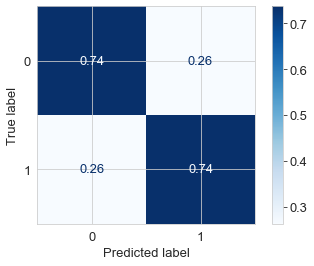

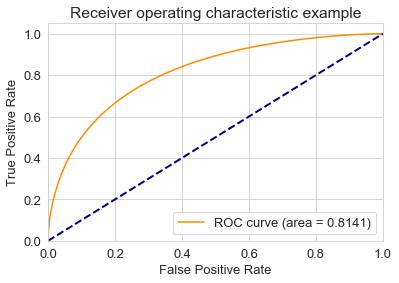

In [63]:
# Base Line Evaluation

#Predicting for testing and trainig data sets
y_test_proba = cb_clf.predict_proba(X_test)[:,1]
y_train_proba = cb_clf.predict_proba(X_train)[:,1]

y_pred_test = cb_clf.predict(X_test)
y_pred_train = cb_clf.predict(X_train)

    #Accuracy Score
print("Training accuracy: %0.4f" %cb_clf.score(X_train, y_train))
print("Test accuracy    : %0.4f" %cb_clf.score(X_test, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(cb_clf, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


In [42]:
#coefficients = xg.feature_importances_
coefficients = cb_clf.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 5:")
print(coef[:11])



Top 5:
                                        Feature Importance
count_song_played                                10.308590
ug_1                                              9.333126
us_1                                              5.008795
artist_name                                       4.670411
source_system_tab_my library                      3.319462
us_3                                              3.159161
source_screen_name_Local playlist more            3.089821
language                                          3.050652
ug_2                                              2.618385
us_5                                              2.236494
us_2                                              2.216048


#### Post Standardization 

In [14]:
def cb_tuning(X_train, y_train, X_test, y_test, para, index):
      
    cb_clf = cb.CatBoostClassifier(random_state = 42, rsm = para, n_estimators = 500)#, 
                                   #min_data_in_leaf = 1, max_depth = 6, rsm  = 0.6, learning_rate = 0.06, 
                                   #verbose = 0, one_hot_max_size = 9)
                                   
    cb_clf.fit(X_train,y_train, cat_features= index)

    y_pred_test = cb_clf.predict(X_test)
    y_pred_train = cb_clf.predict(X_train)
    
    y_test_proba = cb_clf.predict_proba(X_test)[:,1]
    y_train_proba = cb_clf.predict_proba(X_train)[:,1]


    #Accuracy Score
    loss_train = log_loss(y_train, cb_clf.predict_proba(X_train))
    loss_test = log_loss(y_test, cb_clf.predict_proba(X_test))
    #auc_train = roc_auc_score(y_train,y_train_proba)
    #auc_test = roc_auc_score(y_test,y_test_proba)
    
    return loss_train, loss_test
    #return auc_train, auc_test

In [15]:
X_train_s,X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size = 0.90, random_state = 42)

In [16]:
X_train_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737741 entries, 1462893 to 6413414
Columns: 103 entries, song_length to gender_male
dtypes: category(6), float16(34), float32(1), int16(17), int8(1), uint8(44)
memory usage: 143.2 MB


### Hyper-parameter Tuning

In [24]:
from sklearn.model_selection import GridSearchCV

one_hot_max_size = [2, 10, 20, 40, 80]
min_data_in_leaf = [1, 3, 0.1, 0.3]
learning_rate = [0.03, 0.05, 0.1, 0.2] # default 0.1 
max_depth = [2, 5, 10, 15]
n_estimators = [500,750, 1000, 1500] # default 100
subsample = [0.2, 0.3, 0.4, 0.5, 0.6, 0.8 , 0.9, 1]
l2_leaf_reg = [0.001, 0.01, 0.05, 0.1]
rsm = [0.8, 0.9, 1]

train_loss = []
test_loss  = []

for i in rsm:
    print(i)
    train, test = cb_tuning(X_train_s, y_train_s, X_test_s, y_test_s, i, cat_index)
    train_loss.append(train)
    test_loss.append(test)



0.8
Learning rate set to 0.326267
0:	learn: 0.6604314	total: 793ms	remaining: 6m 35s
1:	learn: 0.6423101	total: 1.56s	remaining: 6m 27s
2:	learn: 0.6324178	total: 2.2s	remaining: 6m 4s
3:	learn: 0.6264513	total: 2.95s	remaining: 6m 5s
4:	learn: 0.6228352	total: 3.61s	remaining: 5m 57s
5:	learn: 0.6200809	total: 4.24s	remaining: 5m 49s
6:	learn: 0.6178379	total: 5.04s	remaining: 5m 55s
7:	learn: 0.6155048	total: 5.88s	remaining: 6m 1s
8:	learn: 0.6136124	total: 6.52s	remaining: 5m 55s
9:	learn: 0.6122186	total: 7.3s	remaining: 5m 57s
10:	learn: 0.6110586	total: 8.01s	remaining: 5m 56s
11:	learn: 0.6094816	total: 8.64s	remaining: 5m 51s
12:	learn: 0.6085903	total: 9.39s	remaining: 5m 51s
13:	learn: 0.6074849	total: 10.1s	remaining: 5m 48s
14:	learn: 0.6066517	total: 10.8s	remaining: 5m 48s
15:	learn: 0.6049441	total: 11.4s	remaining: 5m 45s
16:	learn: 0.6040195	total: 12.2s	remaining: 5m 47s
17:	learn: 0.6030489	total: 13s	remaining: 5m 46s
18:	learn: 0.6024292	total: 13.7s	remaining: 5m

156:	learn: 0.5678129	total: 1m 51s	remaining: 4m 3s
157:	learn: 0.5676923	total: 1m 52s	remaining: 4m 2s
158:	learn: 0.5675444	total: 1m 52s	remaining: 4m 1s
159:	learn: 0.5674291	total: 1m 53s	remaining: 4m 1s
160:	learn: 0.5672637	total: 1m 54s	remaining: 4m
161:	learn: 0.5671150	total: 1m 54s	remaining: 3m 59s
162:	learn: 0.5669121	total: 1m 55s	remaining: 3m 58s
163:	learn: 0.5667956	total: 1m 56s	remaining: 3m 57s
164:	learn: 0.5666739	total: 1m 56s	remaining: 3m 57s
165:	learn: 0.5665730	total: 1m 57s	remaining: 3m 56s
166:	learn: 0.5664512	total: 1m 58s	remaining: 3m 55s
167:	learn: 0.5663140	total: 1m 58s	remaining: 3m 54s
168:	learn: 0.5661678	total: 1m 59s	remaining: 3m 53s
169:	learn: 0.5660181	total: 2m	remaining: 3m 52s
170:	learn: 0.5659050	total: 2m	remaining: 3m 52s
171:	learn: 0.5657630	total: 2m 1s	remaining: 3m 51s
172:	learn: 0.5656241	total: 2m 2s	remaining: 3m 50s
173:	learn: 0.5654494	total: 2m 2s	remaining: 3m 50s
174:	learn: 0.5653057	total: 2m 3s	remaining: 3

309:	learn: 0.5520289	total: 3m 36s	remaining: 2m 12s
310:	learn: 0.5519465	total: 3m 37s	remaining: 2m 12s
311:	learn: 0.5518989	total: 3m 38s	remaining: 2m 11s
312:	learn: 0.5517951	total: 3m 38s	remaining: 2m 10s
313:	learn: 0.5517181	total: 3m 39s	remaining: 2m 10s
314:	learn: 0.5516438	total: 3m 40s	remaining: 2m 9s
315:	learn: 0.5515719	total: 3m 40s	remaining: 2m 8s
316:	learn: 0.5514997	total: 3m 41s	remaining: 2m 7s
317:	learn: 0.5514703	total: 3m 42s	remaining: 2m 7s
318:	learn: 0.5514244	total: 3m 43s	remaining: 2m 6s
319:	learn: 0.5513353	total: 3m 43s	remaining: 2m 5s
320:	learn: 0.5512718	total: 3m 44s	remaining: 2m 5s
321:	learn: 0.5511862	total: 3m 44s	remaining: 2m 4s
322:	learn: 0.5510894	total: 3m 45s	remaining: 2m 3s
323:	learn: 0.5510380	total: 3m 46s	remaining: 2m 2s
324:	learn: 0.5509760	total: 3m 47s	remaining: 2m 2s
325:	learn: 0.5509120	total: 3m 47s	remaining: 2m 1s
326:	learn: 0.5508523	total: 3m 48s	remaining: 2m
327:	learn: 0.5507650	total: 3m 49s	remainin

464:	learn: 0.5417119	total: 5m 28s	remaining: 24.7s
465:	learn: 0.5416511	total: 5m 29s	remaining: 24s
466:	learn: 0.5415948	total: 5m 29s	remaining: 23.3s
467:	learn: 0.5415536	total: 5m 30s	remaining: 22.6s
468:	learn: 0.5414811	total: 5m 31s	remaining: 21.9s
469:	learn: 0.5414481	total: 5m 32s	remaining: 21.2s
470:	learn: 0.5413773	total: 5m 32s	remaining: 20.5s
471:	learn: 0.5413473	total: 5m 33s	remaining: 19.8s
472:	learn: 0.5413101	total: 5m 34s	remaining: 19.1s
473:	learn: 0.5412510	total: 5m 34s	remaining: 18.4s
474:	learn: 0.5411637	total: 5m 35s	remaining: 17.7s
475:	learn: 0.5411269	total: 5m 36s	remaining: 17s
476:	learn: 0.5410638	total: 5m 37s	remaining: 16.3s
477:	learn: 0.5410024	total: 5m 37s	remaining: 15.5s
478:	learn: 0.5409616	total: 5m 38s	remaining: 14.8s
479:	learn: 0.5408860	total: 5m 39s	remaining: 14.1s
480:	learn: 0.5408583	total: 5m 39s	remaining: 13.4s
481:	learn: 0.5407316	total: 5m 40s	remaining: 12.7s
482:	learn: 0.5406607	total: 5m 41s	remaining: 12s

121:	learn: 0.5722662	total: 1m 35s	remaining: 4m 56s
122:	learn: 0.5720454	total: 1m 36s	remaining: 4m 55s
123:	learn: 0.5717940	total: 1m 37s	remaining: 4m 54s
124:	learn: 0.5716515	total: 1m 37s	remaining: 4m 53s
125:	learn: 0.5714677	total: 1m 38s	remaining: 4m 53s
126:	learn: 0.5713260	total: 1m 39s	remaining: 4m 52s
127:	learn: 0.5711585	total: 1m 40s	remaining: 4m 51s
128:	learn: 0.5710216	total: 1m 41s	remaining: 4m 50s
129:	learn: 0.5708258	total: 1m 41s	remaining: 4m 50s
130:	learn: 0.5705855	total: 1m 42s	remaining: 4m 49s
131:	learn: 0.5704157	total: 1m 43s	remaining: 4m 48s
132:	learn: 0.5703056	total: 1m 44s	remaining: 4m 47s
133:	learn: 0.5701025	total: 1m 44s	remaining: 4m 46s
134:	learn: 0.5699668	total: 1m 45s	remaining: 4m 45s
135:	learn: 0.5698740	total: 1m 46s	remaining: 4m 45s
136:	learn: 0.5697639	total: 1m 47s	remaining: 4m 44s
137:	learn: 0.5695737	total: 1m 48s	remaining: 4m 43s
138:	learn: 0.5694528	total: 1m 48s	remaining: 4m 42s
139:	learn: 0.5693192	total:

275:	learn: 0.5542701	total: 3m 28s	remaining: 2m 49s
276:	learn: 0.5542049	total: 3m 29s	remaining: 2m 48s
277:	learn: 0.5540837	total: 3m 30s	remaining: 2m 47s
278:	learn: 0.5540377	total: 3m 31s	remaining: 2m 47s
279:	learn: 0.5539803	total: 3m 31s	remaining: 2m 46s
280:	learn: 0.5539154	total: 3m 32s	remaining: 2m 45s
281:	learn: 0.5538027	total: 3m 33s	remaining: 2m 44s
282:	learn: 0.5537129	total: 3m 33s	remaining: 2m 43s
283:	learn: 0.5536393	total: 3m 34s	remaining: 2m 43s
284:	learn: 0.5535002	total: 3m 35s	remaining: 2m 42s
285:	learn: 0.5533822	total: 3m 35s	remaining: 2m 41s
286:	learn: 0.5533340	total: 3m 36s	remaining: 2m 40s
287:	learn: 0.5532734	total: 3m 37s	remaining: 2m 39s
288:	learn: 0.5531660	total: 3m 37s	remaining: 2m 39s
289:	learn: 0.5530569	total: 3m 38s	remaining: 2m 38s
290:	learn: 0.5529413	total: 3m 39s	remaining: 2m 37s
291:	learn: 0.5528936	total: 3m 40s	remaining: 2m 36s
292:	learn: 0.5528266	total: 3m 40s	remaining: 2m 36s
293:	learn: 0.5527611	total:

429:	learn: 0.5429805	total: 5m 19s	remaining: 52s
430:	learn: 0.5428943	total: 5m 20s	remaining: 51.3s
431:	learn: 0.5428186	total: 5m 20s	remaining: 50.5s
432:	learn: 0.5427601	total: 5m 21s	remaining: 49.8s
433:	learn: 0.5427322	total: 5m 22s	remaining: 49s
434:	learn: 0.5426992	total: 5m 23s	remaining: 48.3s
435:	learn: 0.5426210	total: 5m 23s	remaining: 47.5s
436:	learn: 0.5425790	total: 5m 24s	remaining: 46.8s
437:	learn: 0.5425280	total: 5m 25s	remaining: 46s
438:	learn: 0.5424421	total: 5m 25s	remaining: 45.3s
439:	learn: 0.5424106	total: 5m 26s	remaining: 44.5s
440:	learn: 0.5423552	total: 5m 27s	remaining: 43.8s
441:	learn: 0.5422858	total: 5m 28s	remaining: 43s
442:	learn: 0.5422354	total: 5m 28s	remaining: 42.3s
443:	learn: 0.5421530	total: 5m 29s	remaining: 41.6s
444:	learn: 0.5421067	total: 5m 30s	remaining: 40.8s
445:	learn: 0.5420555	total: 5m 31s	remaining: 40.1s
446:	learn: 0.5419906	total: 5m 31s	remaining: 39.3s
447:	learn: 0.5419430	total: 5m 32s	remaining: 38.6s
4

86:	learn: 0.5787068	total: 1m 20s	remaining: 6m 19s
87:	learn: 0.5784160	total: 1m 21s	remaining: 6m 19s
88:	learn: 0.5782399	total: 1m 21s	remaining: 6m 18s
89:	learn: 0.5780624	total: 1m 22s	remaining: 6m 17s
90:	learn: 0.5776411	total: 1m 23s	remaining: 6m 16s
91:	learn: 0.5775038	total: 1m 24s	remaining: 6m 15s
92:	learn: 0.5772987	total: 1m 25s	remaining: 6m 15s
93:	learn: 0.5771243	total: 1m 26s	remaining: 6m 14s
94:	learn: 0.5769591	total: 1m 27s	remaining: 6m 13s
95:	learn: 0.5766731	total: 1m 28s	remaining: 6m 12s
96:	learn: 0.5765083	total: 1m 29s	remaining: 6m 12s
97:	learn: 0.5763914	total: 1m 30s	remaining: 6m 11s
98:	learn: 0.5761428	total: 1m 31s	remaining: 6m 9s
99:	learn: 0.5758100	total: 1m 32s	remaining: 6m 9s
100:	learn: 0.5756789	total: 1m 33s	remaining: 6m 7s
101:	learn: 0.5755578	total: 1m 34s	remaining: 6m 7s
102:	learn: 0.5753994	total: 1m 35s	remaining: 6m 6s
103:	learn: 0.5752607	total: 1m 36s	remaining: 6m 5s
104:	learn: 0.5751182	total: 1m 36s	remaining: 6

240:	learn: 0.5575294	total: 3m 43s	remaining: 4m
241:	learn: 0.5574331	total: 3m 44s	remaining: 3m 59s
242:	learn: 0.5573081	total: 3m 45s	remaining: 3m 58s
243:	learn: 0.5572110	total: 3m 46s	remaining: 3m 57s
244:	learn: 0.5570856	total: 3m 47s	remaining: 3m 56s
245:	learn: 0.5569801	total: 3m 48s	remaining: 3m 55s
246:	learn: 0.5568662	total: 3m 49s	remaining: 3m 55s
247:	learn: 0.5567834	total: 3m 50s	remaining: 3m 54s
248:	learn: 0.5567021	total: 3m 51s	remaining: 3m 53s
249:	learn: 0.5566187	total: 3m 52s	remaining: 3m 52s
250:	learn: 0.5565301	total: 3m 53s	remaining: 3m 51s
251:	learn: 0.5564863	total: 3m 53s	remaining: 3m 50s
252:	learn: 0.5563825	total: 3m 54s	remaining: 3m 49s
253:	learn: 0.5563034	total: 3m 55s	remaining: 3m 48s
254:	learn: 0.5562250	total: 3m 56s	remaining: 3m 47s
255:	learn: 0.5561216	total: 3m 57s	remaining: 3m 46s
256:	learn: 0.5560044	total: 3m 58s	remaining: 3m 45s
257:	learn: 0.5559160	total: 3m 59s	remaining: 3m 44s
258:	learn: 0.5558484	total: 4m	

393:	learn: 0.5452870	total: 6m 3s	remaining: 1m 37s
394:	learn: 0.5452080	total: 6m 4s	remaining: 1m 36s
395:	learn: 0.5451254	total: 6m 5s	remaining: 1m 36s
396:	learn: 0.5450744	total: 6m 6s	remaining: 1m 35s
397:	learn: 0.5449917	total: 6m 7s	remaining: 1m 34s
398:	learn: 0.5449433	total: 6m 8s	remaining: 1m 33s
399:	learn: 0.5449115	total: 6m 9s	remaining: 1m 32s
400:	learn: 0.5448034	total: 6m 10s	remaining: 1m 31s
401:	learn: 0.5447315	total: 6m 11s	remaining: 1m 30s
402:	learn: 0.5446860	total: 6m 12s	remaining: 1m 29s
403:	learn: 0.5446051	total: 6m 13s	remaining: 1m 28s
404:	learn: 0.5445114	total: 6m 14s	remaining: 1m 27s
405:	learn: 0.5444567	total: 6m 14s	remaining: 1m 26s
406:	learn: 0.5443229	total: 6m 15s	remaining: 1m 25s
407:	learn: 0.5442362	total: 6m 16s	remaining: 1m 24s
408:	learn: 0.5441230	total: 6m 17s	remaining: 1m 24s
409:	learn: 0.5440471	total: 6m 18s	remaining: 1m 23s
410:	learn: 0.5440154	total: 6m 19s	remaining: 1m 22s
411:	learn: 0.5439572	total: 6m 20s

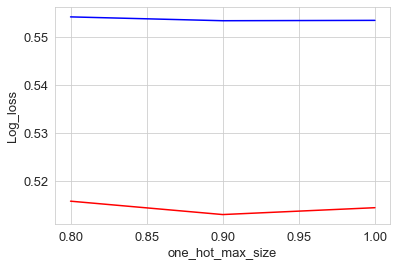

In [25]:
_ = plt.plot(rsm, train_loss, 'r', label = 'Training')
_ = plt.plot(rsm, test_loss, 'b', label = 'Test')
_ = plt.xlabel('one_hot_max_size')
_ = plt.ylabel('Log_loss')


In [26]:
test_loss

[0.5542692989633744, 0.5534665511189657, 0.5535416108519691]

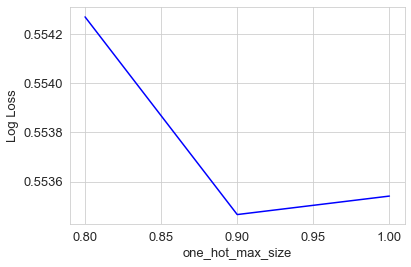

In [27]:
#_ = plt.plot(n_trees, train_auc, 'r', label = 'Training')

_ = plt.plot(rsm, test_loss, 'b', label = 'Test')
_ = plt.xlabel('one_hot_max_size')
_ = plt.ylabel('Log Loss')


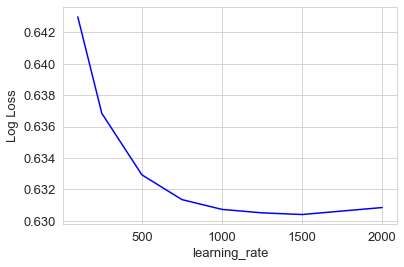

In [133]:
#_ = plt.plot(n_trees, train_auc, 'r', label = 'Training')
_ = plt.plot(n_estimators, test_loss, 'b', label = 'Test')
_ = plt.xlabel('learning_rate')
_ = plt.ylabel('Log Loss')


In [175]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

params = {
    #"gamma": uniform(0.03, 0.3),
    "max_depth": [5, 6, 7], # default 3
    #'min_data_in_leaf' : [3, 4, 6, 10],
    'rsm': [0.5, 0.6, 0.7],
    'subsample': [0.4, 0.5, 0.7, 0.8],
    'l2_leaf_reg' : [5, 15, 20, 25]
    #'one_hot_max_size' : [1, 2, 3, 4, 5, 9]
}

cb_clf = cb.CatBoostClassifier(random_state = 42, min_data_in_leaf = 1, 
                               verbose = 1, one_hot_max_size = 9, learning_rate = 0.06, 
                               cat_features= cat_index_t, n_estimators = 750)
#cv = RandomizedSearchCV(xg, param_distributions=params, random_state=42, 
#                        n_iter=200, cv=5, verbose=2, n_jobs=4, scoring = 'neg_log_loss')

cv = GridSearchCV(cb_clf, param_grid=params, cv=5, verbose=2, n_jobs=4, scoring = 'roc_auc')

cv.fit(X_train_sc,y_train)

print(cv.best_params_)
print(cv.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  8.6min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 37.7min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 85.6min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 161.4min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed: 186.5min finished


0:	learn: 0.6881443	total: 38.7ms	remaining: 29s
1:	learn: 0.6836057	total: 61.9ms	remaining: 23.2s
2:	learn: 0.6798257	total: 87.2ms	remaining: 21.7s
3:	learn: 0.6765531	total: 105ms	remaining: 19.6s
4:	learn: 0.6734150	total: 124ms	remaining: 18.4s
5:	learn: 0.6706243	total: 144ms	remaining: 17.8s
6:	learn: 0.6682969	total: 163ms	remaining: 17.3s
7:	learn: 0.6661204	total: 184ms	remaining: 17.1s
8:	learn: 0.6640831	total: 201ms	remaining: 16.6s
9:	learn: 0.6624779	total: 218ms	remaining: 16.1s
10:	learn: 0.6609824	total: 239ms	remaining: 16s
11:	learn: 0.6594645	total: 256ms	remaining: 15.8s
12:	learn: 0.6580127	total: 275ms	remaining: 15.6s
13:	learn: 0.6568332	total: 294ms	remaining: 15.5s
14:	learn: 0.6557601	total: 315ms	remaining: 15.4s
15:	learn: 0.6547304	total: 331ms	remaining: 15.2s
16:	learn: 0.6537188	total: 352ms	remaining: 15.2s
17:	learn: 0.6528316	total: 370ms	remaining: 15s
18:	learn: 0.6520638	total: 386ms	remaining: 14.9s
19:	learn: 0.6513003	total: 404ms	remaining:

167:	learn: 0.6281513	total: 3s	remaining: 10.4s
168:	learn: 0.6280422	total: 3.02s	remaining: 10.4s
169:	learn: 0.6279793	total: 3.03s	remaining: 10.3s
170:	learn: 0.6279081	total: 3.05s	remaining: 10.3s
171:	learn: 0.6278505	total: 3.07s	remaining: 10.3s
172:	learn: 0.6277925	total: 3.08s	remaining: 10.3s
173:	learn: 0.6277219	total: 3.1s	remaining: 10.3s
174:	learn: 0.6276334	total: 3.12s	remaining: 10.3s
175:	learn: 0.6276035	total: 3.14s	remaining: 10.2s
176:	learn: 0.6275111	total: 3.15s	remaining: 10.2s
177:	learn: 0.6274585	total: 3.17s	remaining: 10.2s
178:	learn: 0.6273848	total: 3.19s	remaining: 10.2s
179:	learn: 0.6273174	total: 3.21s	remaining: 10.2s
180:	learn: 0.6272911	total: 3.24s	remaining: 10.2s
181:	learn: 0.6272344	total: 3.25s	remaining: 10.2s
182:	learn: 0.6271475	total: 3.27s	remaining: 10.1s
183:	learn: 0.6270932	total: 3.3s	remaining: 10.2s
184:	learn: 0.6270188	total: 3.32s	remaining: 10.1s
185:	learn: 0.6269344	total: 3.34s	remaining: 10.1s
186:	learn: 0.626

335:	learn: 0.6163865	total: 5.95s	remaining: 7.33s
336:	learn: 0.6163065	total: 5.97s	remaining: 7.31s
337:	learn: 0.6162462	total: 5.98s	remaining: 7.29s
338:	learn: 0.6161845	total: 6s	remaining: 7.28s
339:	learn: 0.6161272	total: 6.02s	remaining: 7.26s
340:	learn: 0.6160244	total: 6.04s	remaining: 7.24s
341:	learn: 0.6159834	total: 6.05s	remaining: 7.22s
342:	learn: 0.6159082	total: 6.07s	remaining: 7.2s
343:	learn: 0.6158571	total: 6.09s	remaining: 7.18s
344:	learn: 0.6157886	total: 6.11s	remaining: 7.17s
345:	learn: 0.6157214	total: 6.12s	remaining: 7.15s
346:	learn: 0.6157190	total: 6.14s	remaining: 7.13s
347:	learn: 0.6156766	total: 6.16s	remaining: 7.11s
348:	learn: 0.6156256	total: 6.17s	remaining: 7.09s
349:	learn: 0.6155886	total: 6.2s	remaining: 7.08s
350:	learn: 0.6155433	total: 6.21s	remaining: 7.06s
351:	learn: 0.6154808	total: 6.23s	remaining: 7.04s
352:	learn: 0.6154360	total: 6.25s	remaining: 7.03s
353:	learn: 0.6153937	total: 6.26s	remaining: 7s
354:	learn: 0.615366

503:	learn: 0.6080607	total: 8.93s	remaining: 4.36s
504:	learn: 0.6080164	total: 8.94s	remaining: 4.34s
505:	learn: 0.6079458	total: 8.96s	remaining: 4.32s
506:	learn: 0.6079023	total: 8.98s	remaining: 4.3s
507:	learn: 0.6078743	total: 9s	remaining: 4.29s
508:	learn: 0.6078388	total: 9.01s	remaining: 4.27s
509:	learn: 0.6077773	total: 9.03s	remaining: 4.25s
510:	learn: 0.6077339	total: 9.05s	remaining: 4.23s
511:	learn: 0.6076933	total: 9.07s	remaining: 4.21s
512:	learn: 0.6076241	total: 9.09s	remaining: 4.2s
513:	learn: 0.6076191	total: 9.1s	remaining: 4.18s
514:	learn: 0.6075558	total: 9.12s	remaining: 4.16s
515:	learn: 0.6074993	total: 9.14s	remaining: 4.14s
516:	learn: 0.6074670	total: 9.15s	remaining: 4.13s
517:	learn: 0.6074134	total: 9.17s	remaining: 4.11s
518:	learn: 0.6073765	total: 9.2s	remaining: 4.09s
519:	learn: 0.6073445	total: 9.21s	remaining: 4.07s
520:	learn: 0.6073145	total: 9.23s	remaining: 4.06s
521:	learn: 0.6072685	total: 9.25s	remaining: 4.04s
522:	learn: 0.60721

670:	learn: 0.6011550	total: 11.9s	remaining: 1.41s
671:	learn: 0.6011004	total: 12s	remaining: 1.39s
672:	learn: 0.6010703	total: 12s	remaining: 1.37s
673:	learn: 0.6010178	total: 12s	remaining: 1.35s
674:	learn: 0.6009794	total: 12s	remaining: 1.33s
675:	learn: 0.6009115	total: 12s	remaining: 1.32s
676:	learn: 0.6008668	total: 12s	remaining: 1.3s
677:	learn: 0.6008215	total: 12.1s	remaining: 1.28s
678:	learn: 0.6008208	total: 12.1s	remaining: 1.26s
679:	learn: 0.6008202	total: 12.1s	remaining: 1.25s
680:	learn: 0.6007819	total: 12.1s	remaining: 1.23s
681:	learn: 0.6007580	total: 12.1s	remaining: 1.21s
682:	learn: 0.6007082	total: 12.1s	remaining: 1.19s
683:	learn: 0.6007074	total: 12.2s	remaining: 1.17s
684:	learn: 0.6006866	total: 12.2s	remaining: 1.16s
685:	learn: 0.6006429	total: 12.2s	remaining: 1.14s
686:	learn: 0.6006113	total: 12.2s	remaining: 1.12s
687:	learn: 0.6005488	total: 12.2s	remaining: 1.1s
688:	learn: 0.6004893	total: 12.2s	remaining: 1.08s
689:	learn: 0.6004524	tota

0:	learn: 0.6881443	total: 29.5ms	remaining: 22.1s
1:	learn: 0.6836057	total: 55.4ms	remaining: 20.7s
2:	learn: 0.6798257	total: 81.3ms	remaining: 20.3s
3:	learn: 0.6765531	total: 107ms	remaining: 20s
4:	learn: 0.6734150	total: 136ms	remaining: 20.3s
5:	learn: 0.6706243	total: 163ms	remaining: 20.2s
6:	learn: 0.6682969	total: 203ms	remaining: 21.5s
7:	learn: 0.6661204	total: 238ms	remaining: 22.1s
8:	learn: 0.6640831	total: 261ms	remaining: 21.5s
9:	learn: 0.6624779	total: 309ms	remaining: 22.8s
10:	learn: 0.6609824	total: 334ms	remaining: 22.4s
11:	learn: 0.6594645	total: 362ms	remaining: 22.2s
12:	learn: 0.6580127	total: 385ms	remaining: 21.8s
13:	learn: 0.6568332	total: 412ms	remaining: 21.7s
14:	learn: 0.6557601	total: 446ms	remaining: 21.8s
15:	learn: 0.6547304	total: 474ms	remaining: 21.7s
16:	learn: 0.6537188	total: 495ms	remaining: 21.3s
17:	learn: 0.6528316	total: 519ms	remaining: 21.1s
18:	learn: 0.6520638	total: 543ms	remaining: 20.9s
19:	learn: 0.6513003	total: 569ms	remain

167:	learn: 0.6281513	total: 4.59s	remaining: 15.9s
168:	learn: 0.6280422	total: 4.62s	remaining: 15.9s
169:	learn: 0.6279793	total: 4.64s	remaining: 15.8s
170:	learn: 0.6279081	total: 4.67s	remaining: 15.8s
171:	learn: 0.6278505	total: 4.69s	remaining: 15.8s
172:	learn: 0.6277925	total: 4.72s	remaining: 15.7s
173:	learn: 0.6277219	total: 4.75s	remaining: 15.7s
174:	learn: 0.6276334	total: 4.78s	remaining: 15.7s
175:	learn: 0.6276035	total: 4.8s	remaining: 15.7s
176:	learn: 0.6275111	total: 4.83s	remaining: 15.6s
177:	learn: 0.6274585	total: 4.85s	remaining: 15.6s
178:	learn: 0.6273848	total: 4.88s	remaining: 15.6s
179:	learn: 0.6273174	total: 4.91s	remaining: 15.6s
180:	learn: 0.6272911	total: 4.94s	remaining: 15.5s
181:	learn: 0.6272344	total: 4.97s	remaining: 15.5s
182:	learn: 0.6271475	total: 4.99s	remaining: 15.5s
183:	learn: 0.6270932	total: 5.02s	remaining: 15.4s
184:	learn: 0.6270188	total: 5.05s	remaining: 15.4s
185:	learn: 0.6269344	total: 5.07s	remaining: 15.4s
186:	learn: 0

329:	learn: 0.6167637	total: 9.2s	remaining: 11.7s
330:	learn: 0.6167042	total: 9.23s	remaining: 11.7s
331:	learn: 0.6166427	total: 9.25s	remaining: 11.6s
332:	learn: 0.6165471	total: 9.28s	remaining: 11.6s
333:	learn: 0.6164791	total: 9.31s	remaining: 11.6s
334:	learn: 0.6164331	total: 9.33s	remaining: 11.6s
335:	learn: 0.6163865	total: 9.36s	remaining: 11.5s
336:	learn: 0.6163065	total: 9.39s	remaining: 11.5s
337:	learn: 0.6162462	total: 9.41s	remaining: 11.5s
338:	learn: 0.6161845	total: 9.45s	remaining: 11.5s
339:	learn: 0.6161272	total: 9.47s	remaining: 11.4s
340:	learn: 0.6160244	total: 9.51s	remaining: 11.4s
341:	learn: 0.6159834	total: 9.54s	remaining: 11.4s
342:	learn: 0.6159082	total: 9.56s	remaining: 11.3s
343:	learn: 0.6158571	total: 9.59s	remaining: 11.3s
344:	learn: 0.6157886	total: 9.62s	remaining: 11.3s
345:	learn: 0.6157214	total: 9.66s	remaining: 11.3s
346:	learn: 0.6157190	total: 9.68s	remaining: 11.2s
347:	learn: 0.6156766	total: 9.7s	remaining: 11.2s
348:	learn: 0.

492:	learn: 0.6085681	total: 13.8s	remaining: 7.21s
493:	learn: 0.6085014	total: 13.9s	remaining: 7.18s
494:	learn: 0.6084577	total: 13.9s	remaining: 7.15s
495:	learn: 0.6084105	total: 13.9s	remaining: 7.12s
496:	learn: 0.6084026	total: 13.9s	remaining: 7.1s
497:	learn: 0.6083530	total: 14s	remaining: 7.07s
498:	learn: 0.6082897	total: 14s	remaining: 7.04s
499:	learn: 0.6082680	total: 14s	remaining: 7.01s
500:	learn: 0.6081902	total: 14s	remaining: 6.98s
501:	learn: 0.6081355	total: 14.1s	remaining: 6.95s
502:	learn: 0.6080873	total: 14.1s	remaining: 6.93s
503:	learn: 0.6080607	total: 14.1s	remaining: 6.9s
504:	learn: 0.6080164	total: 14.2s	remaining: 6.87s
505:	learn: 0.6079458	total: 14.2s	remaining: 6.84s
506:	learn: 0.6079023	total: 14.2s	remaining: 6.81s
507:	learn: 0.6078743	total: 14.2s	remaining: 6.79s
508:	learn: 0.6078388	total: 14.3s	remaining: 6.76s
509:	learn: 0.6077773	total: 14.3s	remaining: 6.73s
510:	learn: 0.6077339	total: 14.3s	remaining: 6.7s
511:	learn: 0.6076933	t

654:	learn: 0.6018387	total: 18.5s	remaining: 2.68s
655:	learn: 0.6018021	total: 18.5s	remaining: 2.65s
656:	learn: 0.6017620	total: 18.6s	remaining: 2.63s
657:	learn: 0.6017091	total: 18.6s	remaining: 2.6s
658:	learn: 0.6016673	total: 18.6s	remaining: 2.57s
659:	learn: 0.6016314	total: 18.6s	remaining: 2.54s
660:	learn: 0.6015804	total: 18.7s	remaining: 2.51s
661:	learn: 0.6015462	total: 18.7s	remaining: 2.48s
662:	learn: 0.6014873	total: 18.7s	remaining: 2.46s
663:	learn: 0.6014492	total: 18.8s	remaining: 2.43s
664:	learn: 0.6014004	total: 18.8s	remaining: 2.4s
665:	learn: 0.6013690	total: 18.8s	remaining: 2.37s
666:	learn: 0.6013232	total: 18.8s	remaining: 2.34s
667:	learn: 0.6013041	total: 18.9s	remaining: 2.31s
668:	learn: 0.6012570	total: 18.9s	remaining: 2.29s
669:	learn: 0.6012049	total: 18.9s	remaining: 2.26s
670:	learn: 0.6011550	total: 19s	remaining: 2.23s
671:	learn: 0.6011004	total: 19s	remaining: 2.2s
672:	learn: 0.6010703	total: 19s	remaining: 2.17s
673:	learn: 0.6010178

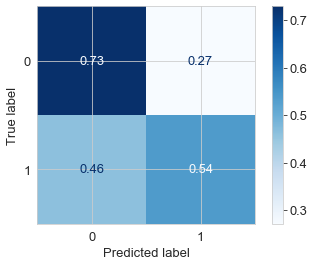

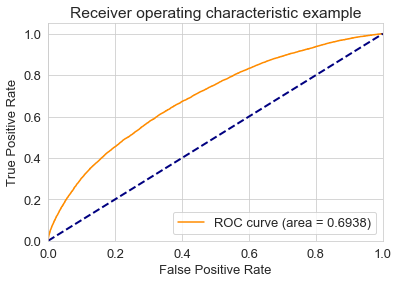

In [16]:
#best_lr = cv.best_estimator_

best_lr = cb.CatBoostClassifier(random_state = 42, min_data_in_leaf = 1, 
                               verbose = 1, one_hot_max_size = 9, learning_rate = 0.06, 
                               cat_features= cat_index_t, n_estimators = 750, l2_leaf_reg = 25,
                                max_depth = 6, rsm = 0.6, subsample = 0.7 )
best_lr.fit(X_train_sc,y_train)

#Predicting for testing and trainig data sets
y_test_proba = best_lr.predict_proba(X_test_sc)[:,1]
y_train_proba = best_lr.predict_proba(X_train_sc)[:,1]

y_pred_test = best_lr.predict(X_test_sc)
y_pred_train = best_lr.predict(X_train_sc)

#Accuracy Score
print("Training accuracy: %0.4f" %best_lr.score(X_train_sc, y_train))
print("Test accuracy    : %0.4f" %best_lr.score(X_test_sc, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(best_lr, X_test_sc, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


Top 25 Feature Importance


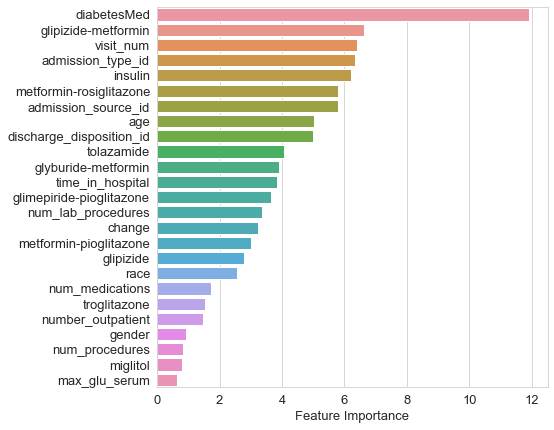

In [21]:
figsize(7,7)

coefficients = best_lr.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 25 Feature Importance")
_ = sns.barplot(data = coef[:25], x = 'Feature Importance', y = coef[:25].index, orient = 'h')
#_ = plt.barh(coef[:10].index, coef['Feature Importance'][:20])

In [26]:
from sklearn.metrics import precision_recall_curve

def pr_auc_curve(y_test,y_pred_test,auc_test):
    precision,recall, threshold = precision_recall_curve(y_test, y_pred_test)
    _ = plt.plot(recall, precision, color='darkorange', label='ROC curve (area = %0.4f)' %auc_test )
    _ = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = plt.xlim([0.0, 1.0])
    _ = plt.ylim([0.0, 1.05])
    _ = plt.xlabel('Recall')
    _ = plt.ylabel('Precision')
    _ = plt.title('Receiver operating characteristic example')
    _ = plt.legend(loc="lower right")

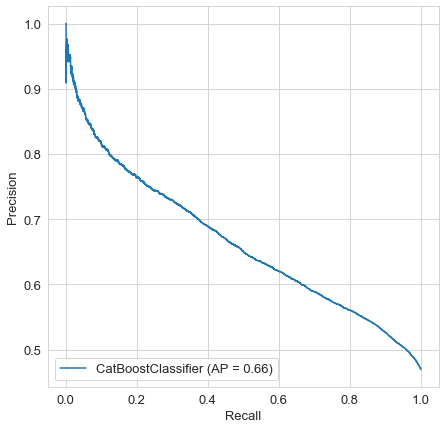

In [28]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(best_lr, X_test_sc, y_test)